In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [ ]:
KEYPOINT_DICT={
    'nose':0,
    'left_eye':1,
    'right_eye':2,
    'left_ear':3,
    'right_ear':4,
    'left_shoulder':5,
    'right_shoulder':6,
    'left_elbow':7,
    'right_elbow':8,
    'left_wrist':9,
    'right_wrist':10,
    'left_hip':11,
    'right_hip':12,
    'left_knee':13,
    'right_knee':14,
    'left_ankle':15,
    'right_ankle':16

}

KEYPOINT_EDGE_INDS_TO_COLOR={
    (0,1):'m',
    (0,2):'c',
    (1,3):'m',
    (2,4):'c',
    (0,5):'m',
    (0,6):'c',
    (5,7):'m',
    (7,9):'m',
    (6,8):'c',
    (8,10):'c',
    (5,6):'y',
    (5,11):'m',
    (6,12):'c',
    (11,12):'y',
    (11,13):'m',
    (13,15):'m',
    (12,14):'c',
    (14,16):'c'
}


In [ ]:
def  _keypoints_and_edges_for_display(keypoints_with_scores,
                                      height,
                                      width,
                                      keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.
  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack([width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold]
    keypoints_all.append(kpts_above_thresh_absolute)
    for edge_pair, edge_color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(edge_color)
    if keypoints_all:
      keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
      keypoints_xy = np.zeros((0, 17, 2))
    if keypoint_edges_all:
      edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
      edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors







In [ ]:
def draw_prediction_on_image(image, keypoints_with_scores, crop_region=None,
                             close_figure=False, output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in the format
      {'y_min': y_min, 'x_min': x_min, 'y_max': y_max, 'x_max': x_max}.
    close_figure: Whether to close the figure after the function call.
    output_image_height: If specified, the height of the output image. If not
      specified, the height of the input image will be used.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin, ymin), rec_width, rec_height,
        linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  # Get the image from the plot using buffer_rgba() and convert to RGB
  image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))
  image_from_plot = image_from_plot[:, :, :3] # Convert RGBA to RGB by removing the alpha channel


  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
        interpolation=cv2.INTER_CUBIC)
  return image_from_plot


  def to_gif(images, fps):
    """Converts image sequence (4D numpy array) to gif."""
    imageio.mimsave('./animation.gif', images, fps=fps)
    return embed.embed_file('./animation.gif')
  def progress(value, max=100):
    return HTML("""
      <progress
        value='{value}'
        max='{max}',
        style='width: 100%'
      >
        {value}
      </progress>
    """.format(value=value,max=max) )

In [ ]:
model_name='movenet_lightning'
if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size=192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size=256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size=192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size=256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  interperter=tf.lite.Interpreter(model_path='model.tflite')
  interperter.allocate_tensors()
  def movenet(input_image):
    """Runs detection on an input image."""
    input_image=tf.cast(input_image,dtype=tf.uint8)
    input_details=interperter.get_input_details()
    output_details=interperter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'],input_image.numpy())
    interpreter.invoke()
    keypoints_with_scores=interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores
else:
    if "movenet_lightning" in model_name:
      module=hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
      input_size=192
    elif "movenet_thunder" in model_name:
      module=hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
      input_size=256
    else:
      raise ValueError("Unsupported model name: %s" % model_name)

    def movenet(input_image):
      """Runs detection on an input image."""
      model=module.signatures['serving_default']
      input_image=tf.cast(input_image,dtype=tf.int32)
      outputs=model(input_image)
      keypoints_with_scores=outputs['output_0'].numpy()
      return keypoints_with_scores

In [ ]:
!curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent

In [ ]:
image_path = 'input_image.jpeg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

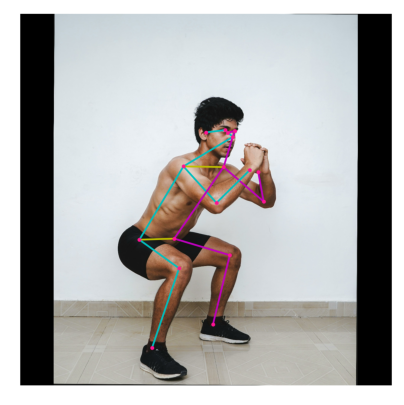

In [ ]:
input_image = tf.expand_dims(image,axis=0)
input_image = tf.image.resize_with_pad(input_image,input_size,input_size)

#Run model inference
keypoints_with_scores = movenet(input_image)

#visualze the predictions with image
display_image = tf.expand_dims(image,axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image,1280,1280),dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(),axis=0),keypoints_with_scores)
plt.figure(figsize=(5,5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [ ]:
MIN_CROP_KEYPOINT_SCORE = 0.2
def init_crop_region(image_height,image_width):
  if image_width > image_height:
    box_height=image_width/image_height
    box_width=1.0
    y_min = (image_height/2-image_width/2)/image_height
    x_min = 0.0

  else:
    box_height = 1.0
    box_width = image_height/image_width
    y_min = 0.0
    x_min = (image_width/2-image_height/2)/image_width
  return{
      'y_min':y_min,
      'x_min':x_min,
      'y_max':y_min+box_height,
      'x_max':x_min + box_width,
      'height':box_height,
      'width':box_width
  }
def torso_visible(keypoints):
  return((
      keypoints[0,0,KEYPOINT_DICT['left_hip'],2]>MIN_CROP_KEYPOINT_SCORE or
      keypoints[0,0,KEYPOINT_DICT['right_hip'],2]>MIN_CROP_KEYPOINT_SCORE and
      keypoints[0,0,KEYPOINT_DICT['left_shoulder'],2]>MIN_CROP_KEYPOINT_SCORE or
      keypoints[0,0,KEYPOINT_DICT['right_shoulder'],2]>MIN_CROP_KEYPOINT_SCORE
  ))


def determine_torso_and_body_range(
    keypoints,target_keypoints,center_y,center_x):
  torso_joints=['left_shoulder','right_shoulder','left_hip','right_hip']
  max_torso_yrange=0.0
  max_torso_xrange=0.0
  for joint in torso_joints:
    dist_y=abs(center_y-target_keypoints[joint][0]);
    dist_x=abs(center_x-target_keypoints[joint][1]);
    if dist_y>max_torso_yrange:
      max_body_yrange=dist_y
    if dist_x>max_torso_xrange:
      max_body_xrange=dist_x
  return [max_torso_yrange,max_torso_xrange,max_body_yrange,max_body_xrange]


def determine_crop_region(keypoints,image_height,image_width):
  target_keypoints={}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint]=[
        keypoints[0,0,KEYPOINT_DICT[joint],0] * image_height,
        keypoints[0,0,KEYPOINT_DICT[joint],1] * image_width
    ]
  if torso_visible(keypoints):
    center_y=(target_keypoints['left_hip'][0]+target_keypoints['right_hip'][0])/2;
    center_x=(target_keypoints['left_hip'][1]+target_keypoints['right_hip'][1])/2;
    (max_torso_yrange,max_torso_xrange,max_body_yrange,max_body_xrange)=determine_torso_and_body_range(
        keypoints,target_keypoints,center_y,center_x)
    crop_length_half=np.amax([max_torso_xrange*1.9,max_torso_yrange*1.9,max_body_yrange*1.2,max_body_xrange*1.2])
    tmp=np.array([center_x,image_width-center_x,center_y,image_height-center_y])
    crop_length_half=np.amin([crop_length_half,np.amax(tmp)]);

    crop_corner=[center_y-crop_length_half,center_x-crop_length_half];
    if crop_length_half>max(image_width,image_height)/2:
      return init_crop_region(image_height,image_width)
    else:
      crop_length=crop_length_half*2;
      return{
          'y_min':crop_corner[0]/image_height,
          'x_min':crop_corner[1]/image_width,
          'y_max':(crop_corner[0]+crop_length)/image_height,
          'x_max':(crop_corner[1]+crop_length)/image_width,
          'height':(crop_corner[0]+crop_length)/image_height-crop_corner[0]/image_height,
          'width':(crop_corner[1]+crop_length)/image_width-crop_corner[1]/image_width
      }
  else:
    return init_crop_region(image_height,image_width)


def crop_and_resize(image,crop_region,crop_size):
  boxes=[[crop_region['y_min'],crop_region['x_min'],
          crop_region['y_max'],crop_region['x_max']]]
  output_image=tf.image.crop_and_resize(
      image,box_indices=[0],boxes=boxes,crop_size=crop_size)
  return output_image

def run_inference(movenet,image,crop_region,crop_size):
  image_height,image_width,_=image.shape
  input_image=crop_and_resize(
      tf.expand_dims(image,axis=0),crop_region,crop_size=crop_size)
  keypoints_with_scores=movenet(input_image)
  for idx in range(17):
    keypoints_with_scores[0,0,idx,0]= (crop_region['y_min']*image_height+(crop_region['height']*image_height)*keypoints_with_scores[0,0,idx,0])/image_height
    keypoints_with_scores[0,0,idx,1]= (crop_region['x_min']*image_width+(crop_region['width']*image_width)*keypoints_with_scores[0,0,idx,1])/image_width
  return keypoints_with_scores

In [ ]:
!wget -q -O dance.gif https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/dance_input.gif

In [ ]:
#Load the input image
image_path = 'dance.gif'
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)


In [ ]:
#Load the input image
num_frames , image_height , image_width,_=image.shape
crop_region=init_crop_region(image_height,image_width)
output_images=[]

# Define the progress function here
def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

bar = display(progress(0,num_frames-1),display_id=True)
for frame_idx in range(num_frames):
  keypoints_with_scores=run_inference(
      movenet,image[frame_idx,:,:,:].numpy(),crop_region,crop_size=[input_size,input_size])
  output_images.append(draw_prediction_on_image(
      image[frame_idx,:,:,:].numpy().astype(np.int32),keypoints_with_scores,crop_region=None,
      close_figure=True,output_image_height=300))
  crop_region=determine_crop_region(keypoints_with_scores,image_height,image_width)
  bar.update(progress(frame_idx,num_frames-1))

  Preparing metadata (setup.py) ... done



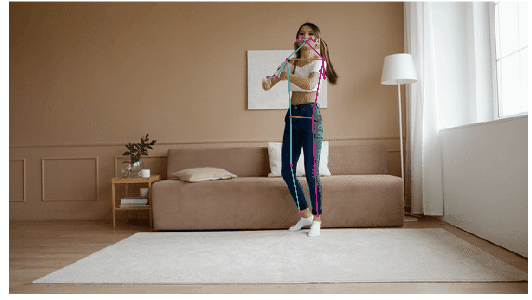

In [ ]:
from IPython import get_ipython
from IPython.display import display, HTML
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import imageio
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Install required packages
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

# Keypoint dictionary and edge colors
KEYPOINT_DICT = {
    'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4,
    'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8,
    'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12,
    'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16
}

KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm', (0, 2): 'c', (1, 3): 'm', (2, 4): 'c', (0, 5): 'm', (0, 6): 'c',
    (5, 7): 'm', (7, 9): 'm', (6, 8): 'c', (8, 10): 'c', (5, 6): 'y',
    (5, 11): 'm', (6, 12): 'c', (11, 12): 'y', (11, 13): 'm', (13, 15): 'm',
    (12, 14): 'c', (14, 16): 'c'
}

# Function to extract keypoints and edges for visualization
def _keypoints_and_edges_for_display(keypoints_with_scores, height, width, keypoint_threshold=0.11):
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack([width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
        kpts_above_thresh_absolute = kpts_absolute_xy[kpts_scores > keypoint_threshold]
        keypoints_all.append(kpts_above_thresh_absolute)
        for edge_pair, edge_color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (kpts_scores[edge_pair[0]] > keypoint_threshold and
                kpts_scores[edge_pair[1]] > keypoint_threshold):
                x_start = kpts_absolute_xy[edge_pair[0], 0]
                y_start = kpts_absolute_xy[edge_pair[0], 1]
                x_end = kpts_absolute_xy[edge_pair[1], 0]
                y_end = kpts_absolute_xy[edge_pair[1], 1]
                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                edge_colors.append(edge_color)
    keypoints_xy = np.concatenate(keypoints_all, axis=0) if keypoints_all else np.zeros((0, 17, 2))
    edges_xy = np.stack(keypoint_edges_all, axis=0) if keypoint_edges_all else np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors

# Fixed draw_prediction_on_image function
def draw_prediction_on_image(image, keypoints_with_scores, crop_region=None,
                             close_figure=False, output_image_height=None):
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle='solid')
    ax.add_collection(line_segments)
    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    keypoints_xy, keypoint_edges, edge_colors = _keypoints_and_edges_for_display(
        keypoints_with_scores, height, width)

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoints_xy.shape[0]:
        scat.set_offsets(keypoints_xy)

    if crop_region is not None:
        xmin = max(crop_region['x_min'] * width, 0.0)
        ymin = max(crop_region['y_min'] * height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99) * width - xmin
        rec_height = min(crop_region['y_max'], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin, ymin), rec_width, rec_height,
            linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)

    fig.canvas.draw()
    # Fix: Use buffer_rgba() and convert to RGB
    image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:, :, :3]  # Strip alpha channel

    if close_figure:
        plt.close(fig)

    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(
            image_from_plot, dsize=(output_image_width, output_image_height),
            interpolation=cv2.INTER_CUBIC)
    return image_from_plot

# Progress bar function
def progress(value, max=100):
    return HTML("""
        <progress value='{value}' max='{max}' style='width: 100%'>
            {value}
        </progress>
    """.format(value=value, max=max))

# Convert images to GIF
def to_gif(images, fps):
    imageio.mimsave('./animation.gif', images, fps=fps)
    return embed.embed_file('./animation.gif')

# Load MoveNet model
model_name = 'movenet_lightning'
if "tflite" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
    interpreter = tf.lite.Interpreter(model_path='model.tflite')
    interpreter.allocate_tensors()

    def movenet(input_image):
        input_image = tf.cast(input_image, dtype=tf.uint8)
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
        interpreter.invoke()
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
        return keypoints_with_scores
else:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192

    def movenet(input_image):
        model = module.signatures['serving_default']
        input_image = tf.cast(input_image, dtype=tf.int32)
        outputs = model(input_image)
        keypoints_with_scores = outputs['output_0'].numpy()
        return keypoints_with_scores

# Crop and resize functions
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
    if image_width > image_height:
        box_height = image_width / image_height
        box_width = 1.0
        y_min = (image_height / 2 - image_width / 2) / image_height
        x_min = 0.0
    else:
        box_height = 1.0
        box_width = image_height / image_width
        y_min = 0.0
        x_min = (image_width / 2 - image_height / 2) / image_width
    return {
        'y_min': y_min, 'x_min': x_min,
        'y_max': y_min + box_height, 'x_max': x_min + box_width,
        'height': box_height, 'width': box_width
    }

def torso_visible(keypoints):
    return (
        (keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] > MIN_CROP_KEYPOINT_SCORE or
         keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] > MIN_CROP_KEYPOINT_SCORE) and
        (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] > MIN_CROP_KEYPOINT_SCORE or
         keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] > MIN_CROP_KEYPOINT_SCORE)
    )

def determine_torso_and_body_range(keypoints, target_keypoints, center_y, center_x):
    torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    max_torso_yrange = 0.0
    max_torso_xrange = 0.0
    for joint in torso_joints:
        dist_y = abs(center_y - target_keypoints[joint][0])
        dist_x = abs(center_x - target_keypoints[joint][1])
        if dist_y > max_torso_yrange:
            max_torso_yrange = dist_y
        if dist_x > max_torso_xrange:
            max_torso_xrange = dist_x
    return [max_torso_yrange, max_torso_xrange, max_torso_yrange, max_torso_xrange]

def determine_crop_region(keypoints, image_height, image_width):
    target_keypoints = {}
    for joint in KEYPOINT_DICT.keys():
        target_keypoints[joint] = [
            keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
            keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
        ]
    if torso_visible(keypoints):
        center_y = (target_keypoints['left_hip'][0] + target_keypoints['right_hip'][0]) / 2
        center_x = (target_keypoints['left_hip'][1] + target_keypoints['right_hip'][1]) / 2
        max_torso_yrange, max_torso_xrange, _, _ = determine_torso_and_body_range(
            keypoints, target_keypoints, center_y, center_x)
        crop_length_half = np.amax([
            max_torso_xrange * 1.9, max_torso_yrange * 1.9,
            max_torso_yrange * 1.2, max_torso_xrange * 1.2
        ])
        tmp = np.array([center_x, image_width - center_x, center_y, image_height - center_y])
        crop_length_half = np.amin([crop_length_half, np.amax(tmp)])
        crop_corner = [center_y - crop_length_half, center_x - crop_length_half]
        if crop_length_half > max(image_width, image_height) / 2:
            return init_crop_region(image_height, image_width)
        else:
            crop_length = crop_length_half * 2
            return {
                'y_min': crop_corner[0] / image_height,
                'x_min': crop_corner[1] / image_width,
                'y_max': (crop_corner[0] + crop_length) / image_height,
                'x_max': (crop_corner[1] + crop_length) / image_width,
                'height': (crop_corner[0] + crop_length) / image_height - crop_corner[0] / image_height,
                'width': (crop_corner[1] + crop_length) / image_width - crop_corner[1] / image_width
            }
    else:
        return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
    boxes = [[crop_region['y_min'], crop_region['x_min'],
              crop_region['y_max'], crop_region['x_max']]]
    output_image = tf.image.crop_and_resize(
        image, box_indices=[0], boxes=boxes, crop_size=crop_size)
    return output_image

def run_inference(movenet, image, crop_region, crop_size):
    image_height, image_width, _ = image.shape
    input_image = crop_and_resize(
        tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
    keypoints_with_scores = movenet(input_image)
    for idx in range(17):
        keypoints_with_scores[0, 0, idx, 0] = (
            crop_region['y_min'] * image_height +
            (crop_region['height'] * image_height) * keypoints_with_scores[0, 0, idx, 0]
        ) / image_height
        keypoints_with_scores[0, 0, idx, 1] = (
            crop_region['x_min'] * image_width +
            (crop_region['width'] * image_width) * keypoints_with_scores[0, 0, idx, 1]
        ) / image_width
    return keypoints_with_scores

# Download and process dance.gif
!wget -q -O dance.gif https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/dance_input.gif

# Load and process the GIF
image_path = 'dance.gif'
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)

# Process each frame
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)
output_images = []
bar = display(progress(0, num_frames - 1), display_id=True)

for frame_idx in range(num_frames):
    keypoints_with_scores = run_inference(
        movenet, image[frame_idx, :, :, :].numpy(), crop_region, crop_size=[input_size, input_size])
    output_images.append(draw_prediction_on_image(
        image[frame_idx, :, :, :].numpy().astype(np.int32), keypoints_with_scores,
        crop_region=None, close_figure=True, output_image_height=300))
    crop_region = determine_crop_region(keypoints_with_scores, image_height, image_width)
    bar.update(progress(frame_idx, num_frames - 1))

# Convert to GIF
to_gif(output_images, fps=10)